Computing transition probabilities:   0%|          | 0/176 [00:00<?, ?it/s]

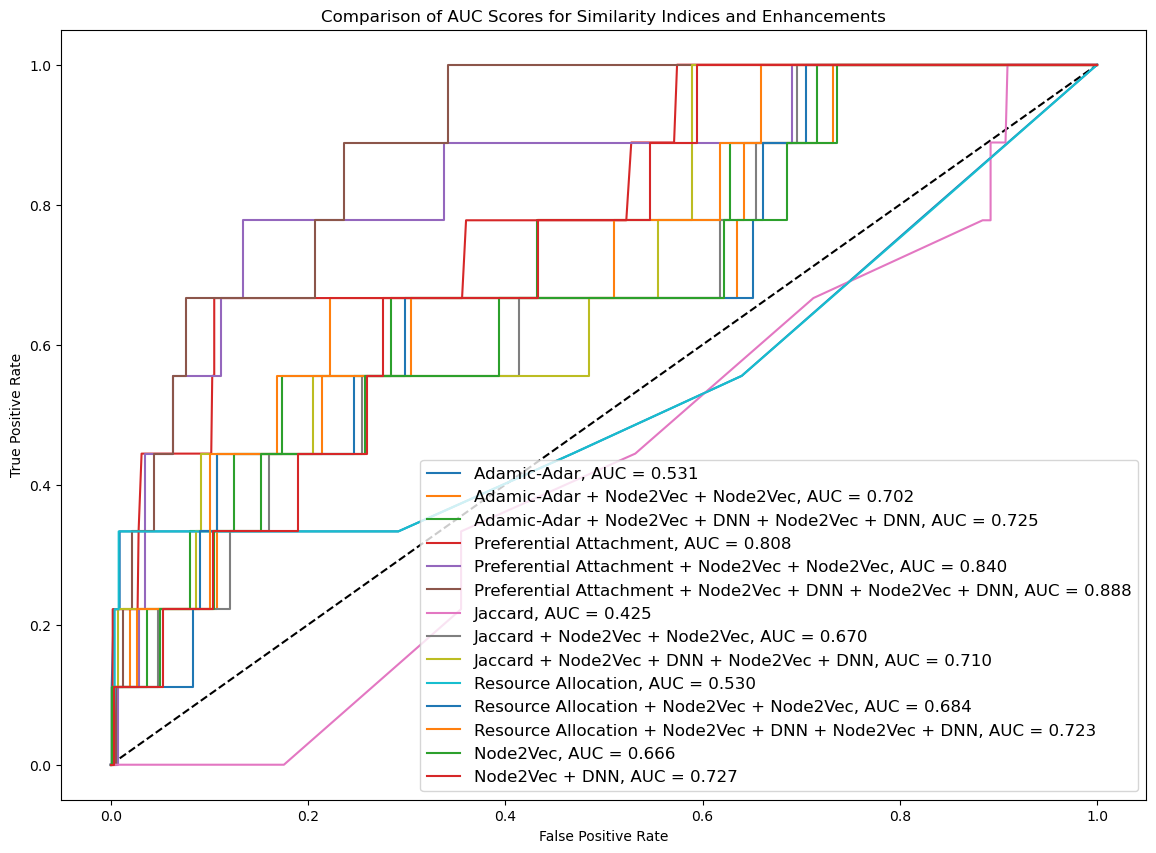

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import random
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from node2vec import Node2Vec

# Load data and create a graph
df2 = pd.read_csv('Alliances.csv')
G = nx.from_pandas_edgelist(df2, 'Side_a', 'Side_b')

# Set random seed for reproducibility
random.seed(10)
np.random.seed(10)

# Generate a test set of unique node pairs
def generate_test_set(G, size):
    test_set = set()
    nodes = list(G.nodes())
    while len(test_set) < size:
        node1, node2 = random.sample(nodes, 2)
        node_pair = tuple(sorted([node1, node2]))
        test_set.add(node_pair)
    return list(test_set)

test_set = generate_test_set(G, 1000)

# Generate Node2Vec embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, seed=12)  
model = node2vec.fit(window=10, min_count=1, batch_words=4)  
embeddings = model.wv

def evaluate_node2vec_embeddings(embeddings, test_set, use_dnn=False):
    X = [np.concatenate((embeddings[node1], embeddings[node2])) for node1, node2 in test_set]
    y_true = [1 if G.has_edge(node1, node2) else 0 for node1, node2 in test_set]
    
    if use_dnn:
        estimator = MLPClassifier(hidden_layer_sizes=(200, 100, 100, 100), max_iter=1000, solver='adam', random_state=10)
    else:
        estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, solver='adam', random_state=10)
    
    y_scores = cross_val_predict(estimator, X, y_true, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    label = "Node2Vec + DNN" if use_dnn else "Node2Vec"
    return fpr, tpr, auc_score, label

# Indices and their functions
indices = {
    'Adamic-Adar': nx.adamic_adar_index,
    'Preferential Attachment': nx.preferential_attachment,
    'Jaccard': nx.jaccard_coefficient,
    'Resource Allocation': nx.resource_allocation_index
}

results = {}
for name, func in indices.items():
    results[name] = evaluate_similarity_index(func, name)
    results[f"{name} + Node2Vec"] = evaluate_similarity_index(func, f"{name} + Node2Vec", use_node2vec=True)
    results[f"{name} + Node2Vec + DNN"] = evaluate_similarity_index(func, f"{name} + Node2Vec + DNN", use_node2vec=True, use_dnn=True)

#Evaluate Node2Vec with and without DNN
results['Node2Vec'] = evaluate_node2vec_embeddings(embeddings, test_set)
results['Node2Vec + DNN'] = evaluate_node2vec_embeddings(embeddings, test_set, use_dnn=True)

# Plot all AUC scores together
plt.figure(figsize=(14, 10))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("Comparison of AUC Scores for Similarity Indices and Enhancements")

for result in results.values():
    fpr, tpr, auc_score, label = result
    plt.plot(fpr, tpr, label=f"{label}, AUC = {auc_score:.3f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=12)
plt.savefig('all_auc_scores_extended.png', dpi=300, bbox_inches = 'tight')
plt.show()

Computing transition probabilities:   0%|          | 0/176 [00:00<?, ?it/s]

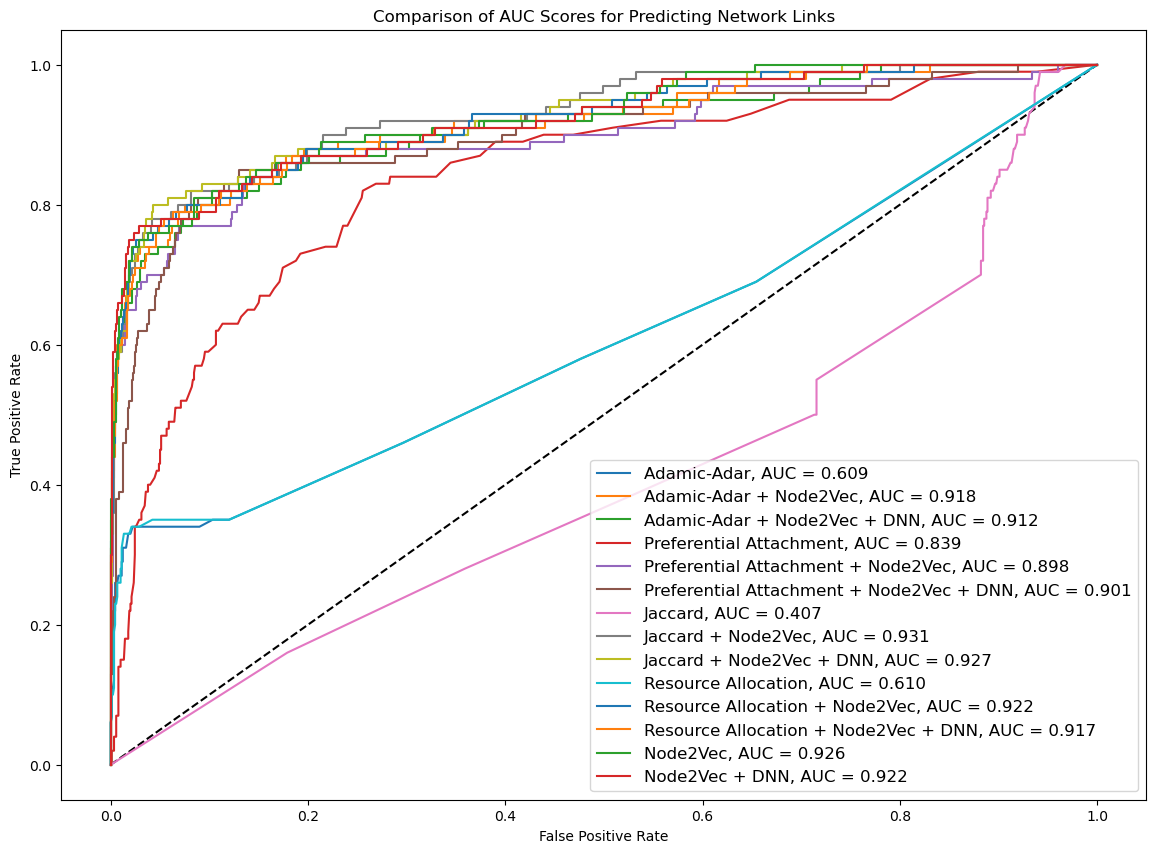

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import random
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from node2vec import Node2Vec

# Load data and create a graph
df2 = pd.read_csv('Alliances.csv')
G = nx.from_pandas_edgelist(df2, 'Side_a', 'Side_b')

# Set random seed for reproducibility
random.seed(10)
np.random.seed(10)

def generate_balanced_test_set(G, num_non_edges, num_positive_edges):
    non_edges = set()
    positive_edges = set()
    nodes = list(G.nodes())
    edges = list(G.edges())

    # Randomly pick non-edges
    while len(non_edges) < num_non_edges:
        node1, node2 = random.sample(nodes, 2)
        if not G.has_edge(node1, node2):
            non_edges.add((node1, node2))

    # Randomly pick edges
    while len(positive_edges) < num_positive_edges:
        positive_edge = random.choice(edges)
        if positive_edge not in positive_edges:
            positive_edges.add(positive_edge)

    # Combine and shuffle
    test_set = list(non_edges) + list(positive_edges)
    random.shuffle(test_set)
    return test_set

test_set = generate_balanced_test_set(G, 900, 100)  # 900 non-edges, 100 edges

# Generate Node2Vec embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, seed=12)  
model = node2vec.fit(window=10, min_count=1, batch_words=4)  
embeddings = model.wv

def evaluate_node2vec_embeddings(embeddings, test_set, use_dnn=False):
    X = [np.concatenate((embeddings[node1], embeddings[node2])) for node1, node2 in test_set]
    y_true = [1 if G.has_edge(node1, node2) else 0 for node1, node2 in test_set]

    if use_dnn:
        estimator = MLPClassifier(hidden_layer_sizes=(200, 100, 100), max_iter=1000, solver='adam', random_state=10)
        label = 'Node2Vec + DNN'
    else:
        estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, solver='adam', random_state=10)
        label = 'Node2Vec'
    
    y_scores = cross_val_predict(estimator, X, y_true, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score, label

def evaluate_similarity_index(index_function, name, use_node2vec=False, use_dnn=False):
    scores = list(index_function(G, test_set))
    if use_node2vec:
        X = [np.concatenate((embeddings[node1], embeddings[node2], [score])) for (node1, node2, score) in scores]
        label_suffix = " + Node2Vec"
    else:
        X = [[score] for _, _, score in scores]
        label_suffix = ""

    if use_dnn:
        estimator = MLPClassifier(hidden_layer_sizes=(200, 100, 100, 100), max_iter=1000, solver='adam', random_state=10)
        label_suffix += " + DNN"
    else:
        estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, solver='adam', random_state=10)

    y_true = [1 if G.has_edge(node1, node2) else 0 for node1, node2 in test_set]
    y_scores = cross_val_predict(estimator, X, y_true, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score, name + label_suffix

indices = {
    'Adamic-Adar': nx.adamic_adar_index,
    'Preferential Attachment': nx.preferential_attachment,
    'Jaccard': nx.jaccard_coefficient,
    'Resource Allocation': nx.resource_allocation_index
}

results = {}
for name, func in indices.items():
    results[name] = evaluate_similarity_index(func, name, use_node2vec=False, use_dnn=False)
    results[name + " + Node2Vec"] = evaluate_similarity_index(func, name, use_node2vec=True, use_dnn=False)
    results[name + " + Node2Vec + DNN"] = evaluate_similarity_index(func, name, use_node2vec=True, use_dnn=True)

# Evaluate Node2Vec standalone and with DNN
results['Node2Vec'] = evaluate_node2vec_embeddings(embeddings, test_set, use_dnn=False)
results['Node2Vec + DNN'] = evaluate_node2vec_embeddings(embeddings, test_set, use_dnn=True)

# Plot all AUC scores together
plt.figure(figsize=(14, 10))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("Comparison of AUC Scores for Predicting Network Links")
for key, (fpr, tpr, auc_score, label) in results.items():
    plt.plot(fpr, tpr, label=f"{label}, AUC = {auc_score:.3f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=12)
plt.savefig('all_auc_scores_for_network_links.png', dpi=300, bbox_inches='tight')
plt.show()

